# A Linear Programming Model for Optimal Transport 

<div class="alert alert-block alert-success">
$\newcommand{\R}{\mathbb{R}} \newcommand{\Z}{\mathbb{Z}} \newcommand{\N}{\mathbb{N}} 
\newcommand{\bff}{\mathbf{f}} \newcommand{\bx}{\mathbf{x}} 
\newcommand{\by}{\mathbf{y}} \newcommand{\bo}{\mathbb{1}} \newcommand{\bJ}{\mathbf{J}}$
In this notebook, we will aim to solve the following optimal transport problem in its linear form:
\begin{align}
\min c^\top x,
\end{align}
subject to
\begin{align}
    \begin{pmatrix} \mathbb{1}_N^\top \otimes I_M \\ I_N \otimes \mathbb{1}_M^\top \end{pmatrix} x &= 
    \begin{pmatrix} m \\ n \end{pmatrix},
    \\
    x &\geq 0;
\end{align}
where $x\in \R^{M\times N}$, $m \in \R^M$, $n \in \R^N$, and $c \in \R^{M\times N}$ is a positive cost vector.
</div>

<div class="alert alert-block alert-info">
The following packages are loaded into the environment. 
</div>

In [1]:
from gurobipy import *
import time
import numpy as np
from numpy         import asarray, indices, double, allclose
from pandas        import read_csv
from skimage.io    import imread, imshow
from scipy.spatial import distance_matrix
from scipy.spatial.distance import cdist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

<div class="alert alert-block alert-success">
We can actually solve the original problem with an LP solver that allows indexing:
\begin{align}
    \min c : \gamma,
\end{align}
subject to
\begin{align}
    \sum_{j} \gamma_{i,j} &= m_i
    \\
    \sum_{i} \gamma_{i,j} &= n_j
    \\
    \gamma_{i,j} &\geq 0.
\end{align}
</div>

<div class="alert alert-block alert-info">
Here we define the following basic objects:
    
1. `M` and `N` are the number of points where the measures of `μ` and `ν` are concentrated,
2. `c` is the vector of costs.
</div>

In [2]:
# File names
Dir  = '../../DOTmark/Data/Shapes/'
Main = 'Shapes_Sized/'
nomᵤ = 'data64_1009.csv'
nomᵥ = 'data128_1009.csv'

In [3]:
μ = read_csv(Dir + nomᵤ).values.astype(double);    μ /= μ.max()
ν = read_csv(Dir + nomᵥ).values.astype(double);    ν /= ν.max()

In [4]:
M = μ.size
N = ν.size

In [5]:
# Coordinates:
Iₘ = (indices(μ.shape)/(asarray(μ.shape)-1)[::,np.newaxis,np.newaxis]).reshape(2,M).T
Iₙ = (indices(ν.shape)/(asarray(ν.shape)-1)[::,np.newaxis,np.newaxis]).reshape(2,N).T
#Sparse alternatives:    indices(μ.shape, sparse=True)      &      indices(ν.shape, sparse=True)

In [6]:
# Cost matrix:
c = cdist(Iₘ, Iₙ, 'sqeuclidean')        # Alternative: distance_matrix(Iₘ, Iₙ) ** 2

In [7]:
P = {'A': (None,'S2'), 'B': (1,'1'), 'C': (1.5,'1.5'), 'D': (2,'2'), 'E': (4,'4'), 'F': (np.inf,'∞')}
test = 'A'

In [8]:
p = '_p=' + P[test][1]

In [9]:
if test != 'A':        c = cdist(Iₘ, Iₙ, 'minkowski', p = P[test][0])

In [9]:
#μ = np.where(μ==0, 1e-4, μ)
#ν = np.where(ν==0, 1e-4, ν)

In [10]:
m = μ.ravel() / μ.sum()
n = ν.ravel() / ν.sum()

<div class="alert alert-block alert-warning">
Optimisation model
</div>

In [11]:
# Model
start = time.time()
mo = Model()
γ  = {}
γ = mo.addMVar( (M,N), vtype = 'C', name ='g', obj = c, lb = 0.0)

mo.addConstrs( (γ[i,:].sum() == m[i] for i in range(M)), name='m' );
mo.addConstrs( (γ[:,j].sum() == n[j] for j in range(N)), name='n');
end = time.time()
print(end-start)

Academic license - for non-commercial use only - expires 2021-10-01
Using license file /Users/andy/gurobi.lic
1154.680979013443


In [64]:
γ.setAttr('obj', c)

In [12]:
mo.Params.IntFeasTol, mo.Params.FeasibilityTol, mo.Params.OptimalityTol = 1e-9, 1e-9, 1e-9

Changed value of parameter IntFeasTol to 1e-09
   Prev: 1e-05  Min: 1e-09  Max: 0.1  Default: 1e-05
Changed value of parameter FeasibilityTol to 1e-09
   Prev: 1e-06  Min: 1e-09  Max: 0.01  Default: 1e-06
Changed value of parameter OptimalityTol to 1e-09
   Prev: 1e-06  Min: 1e-09  Max: 0.01  Default: 1e-06


In [ ]:
mo.reset();    mo.setParam('Method', 0);    mo.Params.Presolve = 0;    mo.optimize()
#?mo.Params.Method

Discarded solution information
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 20288 rows, 65544192 columns and 131088384 nonzeros
Model fingerprint: 0xa7f3c335
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-08, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-04, 5e-04]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3352868e+00   9.993809e-01   6.552600e+13     24s
    9324    1.0942872e+00   9.130695e-01   6.230117e+13     28s
   18648    1.0000039e+00   8.704439e-01   5.585938e+13     32s
   27972    8.3541995e-01   7.791409e-01   5.027742e+13     37s
   37296    7.6303974e-01   7.282195e-01   4.500323e+13     41s
   46620    6.5648616e-01 

 1118206   -4.3751242e-01   0.000000e+00   2.533538e+07    768s
 1127395   -4.3818332e-01   0.000000e+00   1.750213e+07    774s
 1136719   -4.3874351e-01   0.000000e+00   2.628558e+07    780s
 1145926   -4.3949525e-01   0.000000e+00   3.293417e+07    786s
 1155250   -4.4060144e-01   0.000000e+00   6.892677e+07    792s
 1164574   -4.4155966e-01   0.000000e+00   9.631492e+07    798s
 1173898   -4.4238939e-01   0.000000e+00   1.396283e+08    804s
 1183222   -4.4325880e-01   0.000000e+00   7.965765e+07    811s
 1192546   -4.4377975e-01   0.000000e+00   4.772652e+07    817s
 1201870   -4.4466162e-01   0.000000e+00   3.511942e+07    823s
 1211194   -4.4521035e-01   0.000000e+00   7.728124e+07    829s
 1220518   -4.4620874e-01   0.000000e+00   4.559242e+07    836s
 1229842   -4.4689641e-01   0.000000e+00   7.180604e+06    842s
 1238757   -4.4742628e-01   0.000000e+00   1.572278e+07    846s
 1248041   -4.4790150e-01   0.000000e+00   1.518425e+07    851s
 1257365   -4.4844610e-01   0.000000e+00

 2196036   -4.8154117e-01   0.000000e+00   3.690687e+04   1442s
 2200259   -4.8155688e-01   0.000000e+00   5.437344e+04   1446s
 2204510   -4.8157526e-01   0.000000e+00   8.328753e+04   1451s
 2208896   -4.8159069e-01   0.000000e+00   2.986174e+05   1455s
 2214483   -4.8160622e-01   0.000000e+00   1.000088e+05   1462s
 2218849   -4.8162044e-01   0.000000e+00   2.472767e+05   1467s
 2223627   -4.8163364e-01   0.000000e+00   9.318197e+04   1474s
 2228657   -4.8164887e-01   0.000000e+00   1.165963e+05   1481s
 2233052   -4.8166431e-01   0.000000e+00   1.179809e+05   1485s
 2242353   -4.8169401e-01   0.000000e+00   1.513509e+05   1494s
 2246668   -4.8170855e-01   0.000000e+00   1.082430e+05   1498s
 2251178   -4.8172219e-01   0.000000e+00   1.230759e+05   1503s
 2255455   -4.8173503e-01   0.000000e+00   9.047214e+04   1507s
 2260429   -4.8174976e-01   0.000000e+00   7.031755e+04   1514s
 2265776   -4.8176379e-01   0.000000e+00   7.126453e+04   1520s
 2270374   -4.8177648e-01   0.000000e+00

 2599576   -2.8007822e-02   1.965281e+01   0.000000e+00   2417s
 2599958   -2.7985381e-02   2.097312e+01   0.000000e+00   2429s
 2600589   -2.7952673e-02   2.120129e+01   0.000000e+00   2442s
 2601079   -2.7921616e-02   2.312027e+01   0.000000e+00   2456s
 2601582   -2.7887426e-02   1.996625e+01   0.000000e+00   2472s
 2601952   -2.7866935e-02   1.629032e+01   0.000000e+00   2484s
 2602435   -2.7841881e-02   2.498986e+01   0.000000e+00   2498s
 2602785   -2.7818294e-02   2.514003e+01   0.000000e+00   2512s
 2603054   -2.7803218e-02   2.106373e+01   0.000000e+00   2522s
 2603445   -2.7783709e-02   1.801032e+01   0.000000e+00   2533s
 2603868   -2.7758374e-02   1.782620e+01   0.000000e+00   2548s
 2604270   -2.7739881e-02   1.652068e+01   0.000000e+00   2559s
 2604557   -2.7724911e-02   2.259405e+01   0.000000e+00   2569s
 2604976   -2.7698547e-02   2.056494e+01   0.000000e+00   2582s
 2605538   -2.7676010e-02   1.833860e+01   0.000000e+00   2598s
 2605978   -2.7633625e-02   4.210219e+01

 2637335   -2.4198806e-02   2.262908e+01   0.000000e+00   3933s
 2637585   -2.4176155e-02   2.969642e+01   0.000000e+00   3945s
 2637705   -2.4166284e-02   2.987338e+01   0.000000e+00   3956s
 2637865   -2.4149809e-02   5.201438e+01   0.000000e+00   3968s
 2638065   -2.4136842e-02   2.212139e+01   0.000000e+00   3979s
 2638265   -2.4119138e-02   4.626620e+01   0.000000e+00   3989s
 2638595   -2.4100353e-02   3.689373e+01   0.000000e+00   4003s
 2638735   -2.4088334e-02   4.976306e+01   0.000000e+00   4013s
 2639035   -2.4068863e-02   2.600511e+01   0.000000e+00   4024s
 2639155   -2.4055486e-02   3.055632e+01   0.000000e+00   4035s
 2639415   -2.4035286e-02   3.211671e+01   0.000000e+00   4047s
 2639605   -2.4017907e-02   2.464685e+01   0.000000e+00   4059s
 2639834   -2.4005311e-02   3.371208e+01   0.000000e+00   4066s
 2640064   -2.3983418e-02   3.141125e+01   0.000000e+00   4078s
 2640244   -2.3972376e-02   5.184896e+01   0.000000e+00   4090s
 2640604   -2.3947068e-02   3.586120e+01

 2666704   -2.1950833e-02   2.883063e+01   0.000000e+00   5693s
 2666904   -2.1938518e-02   1.924955e+01   0.000000e+00   5704s
 2667104   -2.1912471e-02   2.091539e+01   0.000000e+00   5725s
 2667254   -2.1890714e-02   2.553998e+01   0.000000e+00   5747s
 2667444   -2.1863954e-02   2.684729e+01   0.000000e+00   5769s
 2667594   -2.1851949e-02   4.806413e+01   0.000000e+00   5783s
 2667734   -2.1842813e-02   2.710259e+01   0.000000e+00   5797s
 2667964   -2.1817671e-02   3.563378e+01   0.000000e+00   5820s
 2668144   -2.1804902e-02   2.055995e+01   0.000000e+00   5831s
 2668244   -2.1794943e-02   3.323984e+01   0.000000e+00   5842s
 2668534   -2.1772272e-02   2.944012e+01   0.000000e+00   5855s
 2668634   -2.1759445e-02   2.199336e+01   0.000000e+00   5868s
 2668784   -2.1745739e-02   4.393299e+01   0.000000e+00   5879s
 2669224   -2.1714553e-02   2.286637e+01   0.000000e+00   5903s
 2669744   -2.1687270e-02   1.962375e+01   0.000000e+00   5920s
 2670294   -2.1657960e-02   2.024665e+01

 2702014   -1.9785574e-02   2.347656e+01   0.000000e+00   7639s
 2702164   -1.9772433e-02   2.440334e+01   0.000000e+00   7651s
 2702384   -1.9764126e-02   2.300473e+01   0.000000e+00   7666s
 2702624   -1.9747858e-02   2.054355e+01   0.000000e+00   7680s
 2702984   -1.9729256e-02   2.610532e+01   0.000000e+00   7694s
 2703204   -1.9721582e-02   1.783593e+01   0.000000e+00   7706s
 2703474   -1.9706615e-02   2.284893e+01   0.000000e+00   7717s
 2703804   -1.9692521e-02   2.604179e+01   0.000000e+00   7729s
 2704004   -1.9682362e-02   3.161060e+01   0.000000e+00   7739s
 2704224   -1.9666162e-02   3.142044e+01   0.000000e+00   7751s
 2704404   -1.9659556e-02   2.879916e+01   0.000000e+00   7763s
 2704694   -1.9642719e-02   3.201023e+01   0.000000e+00   7775s
 2705044   -1.9624660e-02   4.170714e+01   0.000000e+00   7791s
 2705344   -1.9607789e-02   4.073878e+01   0.000000e+00   7808s
 2705634   -1.9594290e-02   3.034818e+01   0.000000e+00   7823s
 2706154   -1.9574390e-02   3.893010e+01

 2732768   -1.8229147e-02   3.882637e+01   0.000000e+00   9410s
 2732878   -1.8221921e-02   1.805084e+01   0.000000e+00   9423s
 2732998   -1.8211999e-02   4.035184e+01   0.000000e+00   9436s
 2733378   -1.8192277e-02   2.929459e+01   0.000000e+00   9465s
 2733628   -1.8181418e-02   1.537721e+01   0.000000e+00   9478s
 2733968   -1.8160233e-02   3.094937e+01   0.000000e+00   9502s
 2734298   -1.8147393e-02   4.723942e+01   0.000000e+00   9519s
 2734548   -1.8138095e-02   2.257852e+01   0.000000e+00   9535s
 2734788   -1.8120038e-02   1.823337e+01   0.000000e+00   9554s
 2735078   -1.8105121e-02   3.909714e+01   0.000000e+00   9568s
 2735388   -1.8094901e-02   2.287691e+01   0.000000e+00   9584s
 2735518   -1.8082891e-02   2.122925e+01   0.000000e+00   9598s
 2735708   -1.8070035e-02   2.936108e+01   0.000000e+00   9611s
 2735888   -1.8053236e-02   3.831386e+01   0.000000e+00   9636s
 2735998   -1.8047858e-02   2.854053e+01   0.000000e+00   9650s
 2736258   -1.8034577e-02   3.919360e+01

 2766062   -1.6725591e-02   1.763637e+01   0.000000e+00  11370s
 2766432   -1.6709569e-02   1.818735e+01   0.000000e+00  11384s
 2766742   -1.6697988e-02   3.000483e+01   0.000000e+00  11397s
 2767102   -1.6684876e-02   2.409939e+01   0.000000e+00  11413s
 2767322   -1.6673828e-02   2.076252e+01   0.000000e+00  11428s
 2767432   -1.6663673e-02   1.932394e+01   0.000000e+00  11439s
 2767612   -1.6653048e-02   2.772294e+01   0.000000e+00  11452s
 2767712   -1.6642560e-02   3.126621e+01   0.000000e+00  11463s
 2767832   -1.6635883e-02   2.262790e+01   0.000000e+00  11475s
 2768002   -1.6629974e-02   2.638609e+01   0.000000e+00  11486s
 2768192   -1.6622303e-02   1.494433e+01   0.000000e+00  11497s
 2768302   -1.6614550e-02   1.540391e+01   0.000000e+00  11508s
 2768542   -1.6592710e-02   1.522276e+01   0.000000e+00  11529s
 2768832   -1.6577447e-02   1.415702e+01   0.000000e+00  11552s
 2768932   -1.6571333e-02   1.623550e+01   0.000000e+00  11574s
 2769122   -1.6559628e-02   3.303369e+01

 2794147   -1.5496948e-02   3.128849e+01   0.000000e+00  13281s
 2794257   -1.5490570e-02   1.614217e+01   0.000000e+00  13293s
 2794507   -1.5477287e-02   1.473699e+01   0.000000e+00  13317s
 2794647   -1.5472671e-02   3.218889e+01   0.000000e+00  13332s
 2794767   -1.5468727e-02   1.834865e+01   0.000000e+00  13343s
 2794947   -1.5463568e-02   2.075574e+01   0.000000e+00  13353s
 2795077   -1.5450594e-02   3.179520e+01   0.000000e+00  13369s
 2795317   -1.5439114e-02   2.119114e+01   0.000000e+00  13396s
 2795457   -1.5435140e-02   2.267091e+01   0.000000e+00  13408s
 2795637   -1.5427187e-02   2.969233e+01   0.000000e+00  13420s
 2795797   -1.5419804e-02   2.301877e+01   0.000000e+00  13435s
 2795937   -1.5414090e-02   3.423611e+01   0.000000e+00  13448s
 2796177   -1.5400316e-02   3.057722e+01   0.000000e+00  13473s
 2796397   -1.5389312e-02   1.763128e+01   0.000000e+00  13486s
 2796577   -1.5380440e-02   2.647525e+01   0.000000e+00  13499s
 2796757   -1.5373505e-02   2.316085e+01

 2819340   -1.4421454e-02   1.465177e+01   0.000000e+00  15345s
 2819540   -1.4411584e-02   2.625592e+01   0.000000e+00  15370s
 2819720   -1.4407314e-02   1.986851e+01   0.000000e+00  15382s
 2819850   -1.4399896e-02   2.102281e+01   0.000000e+00  15395s
 2819970   -1.4391934e-02   1.901647e+01   0.000000e+00  15407s
 2820170   -1.4381738e-02   1.921219e+01   0.000000e+00  15422s
 2820400   -1.4374267e-02   2.228827e+01   0.000000e+00  15436s
 2820550   -1.4367280e-02   1.798538e+01   0.000000e+00  15449s
 2820720   -1.4359869e-02   2.482442e+01   0.000000e+00  15463s
 2820840   -1.4351097e-02   4.038534e+01   0.000000e+00  15486s
 2821030   -1.4341482e-02   1.301899e+01   0.000000e+00  15510s
 2821220   -1.4332117e-02   2.474611e+01   0.000000e+00  15522s
 2821350   -1.4326340e-02   2.895517e+01   0.000000e+00  15534s
 2821610   -1.4312488e-02   2.812958e+01   0.000000e+00  15571s
 2821800   -1.4303865e-02   4.217635e+01   0.000000e+00  15596s
 2821930   -1.4299268e-02   1.983107e+01

 2846353   -1.3475867e-02   1.478804e+01   0.000000e+00  17550s
 2846613   -1.3462986e-02   1.147619e+01   0.000000e+00  17573s


In [ ]:
# Solve with barrier
mo.reset();    mo.setParam('Method', 2);    mo.optimize()

In [16]:
Exact_performance = {
    'Builder': '1154.680979013443 seconds',
    'Simplex': '89550 iterations and 137.67 seconds', 
    'Barrier': '4289 iterations and 29.79 seconds',
    'Obj': mo.ObjVal
}

<div class="alert alert-block alert-warning">
Output
</div>

In [ ]:
plt.figure(figsize = (15,15))
plt.spy(γ.x, markersize=1, aspect = 5, markeredgecolor = 'orange', alpha=0.5);    plt.axis('off')
plt.savefig(Main + nomᵤ[:-4] + '-' + nomᵥ[:-4] + p + '_Plot.pdf', bbox_inches='tight',transparent=True)
plt.show()

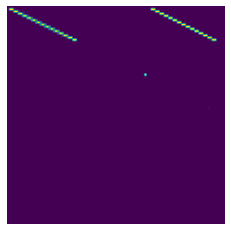

In [21]:
plt.imshow(γ.x[:100,:100]);  plt.axis('off');  
plt.show()

In [14]:
print(γ.x[:13,:3])

[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.00064002 0.00030815]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]


Now we check that the conditional densities coincide:

In [15]:
allclose(γ.x.sum(0), n), allclose(γ.x.sum(1), m)

(True, True)

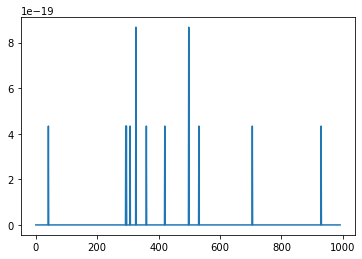

In [16]:
plt.plot( abs(γ.x.sum(0) - n) );    plt.show()

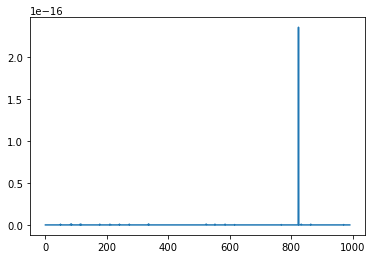

In [17]:
plt.plot( abs(γ.x.sum(1) - m) );    plt.show()

We can then export our inputs and outputs for comparison:

In [ ]:
np.save(Main + nomᵤ[:-4] + '-' + nomᵥ[:-4] + p + '_Cost',   c)    # Cost matrix c
np.save(Main + nomᵤ[:-4] + '-' + nomᵥ[:-4] + p + '_m'   ,   m)    # Source measure m
np.save(Main + nomᵤ[:-4] + '-' + nomᵥ[:-4] + p + '_n'   ,   n)    # Target measure m
np.save(Main + nomᵤ[:-4] + '-' + nomᵥ[:-4] + p + '_Sol' , γ.x)    # Source measure m

In [ ]:
with open(Main + nomᵤ[:-4] + '-' + nomᵥ[:-4] + p + '_Time'+'.txt', 'w') as f:
    print(Exact_performance, file=f)

---